This notebook is intended as a companion to the paper "Robust inference of neutron-star parameters from thermonuclear burst observations" by D. K. Galloway et al., and includes simple examples of using methods as part of the `concord` repository to demonstrate the inference of neutron star properties & burst fuel composition from observations and comparison with simulated data. 

The sections below largely follow the discussion in the paper, and include examples of data analysis from 
1. 4U 0513+40
1. IGR J00291+5934
1. IGR J17591-2342
1. XMMU J181227.8-181234 (= XTE J1812-182)
1. GS 1826-24
1. _and possibly_ SAX J1810.8-2609

The analysis approaches are broken into cases where you have 0, 1, 2 or more bursts; and for 2 or more, you can divide further into cases where you have no adjacent bursts, but can estimate an average recurrence time (e.g. in the case of XMMU J181227.8-181234; goodwin19b). See below for these examples

The notebook has been tested with the following packages:
* `matplotlib` 3.4.3
* `astropy` 4.3.1

### Future work

To do before making this available to users:
* Expand the references to proper links, and in-line citations
* Clean up the code and comments, and remove extraneous stuff
* Add in a routine to do the distance estimate as for XMMU J181227.8-181234, where you compare the mdot implied by the burst recurrence time to the persistent flux

### Modification history

`hfrac` has been further updated to calculate the H-fraction even when the hydrogen is exhausted at the base

The `hfrac` function and the results have been updated for the new $Q_{\rm nuc}$ coefficients derived by Adelle on 25/6/18

### Functions

Here we define the routine(s) that do the heavy lifting; as of 2019 Aug these have been incorporated into `concord`

```
Q_nuc
hfrac
iso_dist
dist
mdot
yign
L_Edd
```

In [1]:
import concord as cd
import astropy.constants as const
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support 
import astropy.uncertainty as unc

from chainconsumer import ChainConsumer
from numpy.random import normal, multivariate_normal

%matplotlib inline

flux_unit = u.erg/u.cm**2/u.s
mdot_Edd = 8.8e4*u.g/u.cm**2/u.s

# Just checking

import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

import sys
print ('Python version {}'.format(sys.version))

matplotlib: 3.4.3
Python version 3.8.5 (v3.8.5:580fbb018f, Jul 20 2020, 12:11:27) 
[Clang 6.0 (clang-600.0.57)]


## Peak luminosity of a burst

This section provides a simple introduction to the routines of the code and how incorporating the astrophysical uncertainties can affect the measurements. We adopt measurements of peak flux for a burst from 4U 0513+40 measured by _RXTE_, as part of the MINBAR sample (Galloway et al. 2020).

In [13]:
# Retrieve the burst measurements from MINBAR

import minbar as mb

b = mb.Bursts()
id = 3443 # burst from 4U~0513-40 with RXTE/PCA on MJD 54043.68857 obsID 92403-01-15-04
F_pk, F_pk_err = b[id]['bpflux'], b[id]['e_bpflux']
print ('''Burst #{}, observed from {} on MJD {:.5f} (obsid {});
  Peak (bolometric) flux is {:.2f} +/- {:.2f} E-9 erg/cm^2/s'''.format(
    id, b[id]['name'], b[id]['time'], b[id]['obsid'], F_pk, F_pk_err))

d = (10.32, 0.24, 0.20) # Watkins et al. 2015

# Now calculate the various luminosities
# In the absence of units for the flux, MINBAR units are assumed; in this case 1e-9 erg/cm^2/s
l_iso = cd.luminosity( F_pk, dist=d[0], isotropic=True )

# For the MCMC version, we use 10000 samples (1000 is the default) to get smoother 
# distributions for final values
l_asym = cd.luminosity( (F_pk, F_pk_err), dist=d, burst=True, imin=80, imax=90, 
                        fulldist=True, nsamp=10000)
lc = l_asym['lum'].pdf_percentiles([50, 50 - cd.CONF / 2, 50 + cd.CONF / 2])

l_unit = 1e38*u.erg/u.s
print ('''\nIsotropic luminosity is {:.2f}e38 erg/s
  Taking into account anisotropy, ({:.2f}-{:.2f}+{:.2f})e38 erg/s'''.format(l_iso/l_unit, 
                                                                            lc[0]/l_unit, 
                                                (lc[0]-lc[1])/l_unit, (lc[2]-lc[0])/l_unit))

Burst #3443, observed from 4U 0513-40 on MJD 54043.68857 (obsid 92403-01-15-04);
  Peak (bolometric) flux is 21.72 +/- 0.60 E-9 erg/cm^2/s

Isotropic luminosity is 2.77e38 erg/s
  Taking into account anisotropy, (4.85-0.42+0.47)e38 erg/s


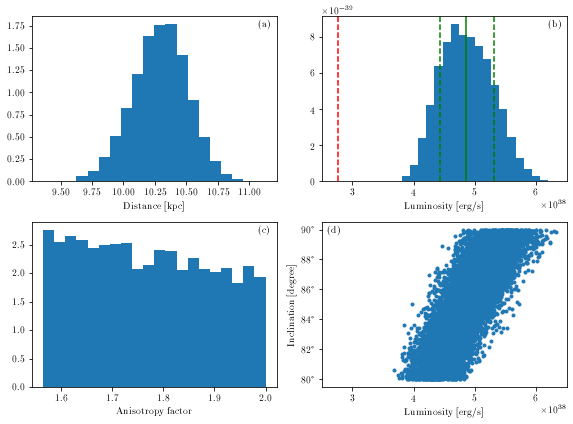

In [14]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# https://www.kite.com/python/answers/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python

fig0, axs0 = plt.subplots(2, 2)
fig0.set_size_inches(8,6)

with quantity_support():
    axs0[0, 1].hist(l_asym['lum'].distribution,bins=20,density=True, 
         label='Luminosity (erg/s)')
    axs0[0, 1].axvline(l_iso,color='r',ls='--')
    axs0[0, 1].axvline(lc[1],color='g',ls='--')
    axs0[0, 1].axvline(lc[2],color='g',ls='--')
    axs0[0, 1].set_xlim((2.5e38,6.5e38))
    axs0[0, 1].set_xlabel('Luminosity [erg/s]')
    axs0[0, 1].axvline(lc[0],color='g')
    
    axs0[0, 1].text(0.95, 0.95, '(b)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[0,1].transAxes)

    axs0[0,0].hist(l_asym['dist'].distribution, bins=20, density=True)
    axs0[0,0].set_xlabel('Distance [kpc]')
    
    axs0[0, 0].text(0.95, 0.95, '(a)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[0,0].transAxes)

    axs0[1,1].plot(l_asym['lum'].distribution, l_asym['i'].distribution, '.')
    # axs0[1,1].set_xlim((2.5e38,6.5e38))
    axs0[1, 1].sharex(axs0[0, 1])
    axs0[1,1].set_xlabel('Luminosity [erg/s]')
    axs0[1,1].set_ylabel('Inclination [degree]')

    axs0[1, 1].text(0.05, 0.95, '(d)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[1,1].transAxes)

    axs0[1,0].hist(l_asym['xi'].distribution, bins=20, density=True)
    axs0[1,0].set_xlabel('Anisotropy factor')

    axs0[1,0].text(0.95, 0.95, '(c)', horizontalalignment='center',
      verticalalignment='center', transform=axs0[1,0].transAxes)


fig0.tight_layout()
# fig0.savefig("fig0.pdf", bbox_inches='tight')

## Zero bursts

Here we compare the results from a study of the accretion-powered millisecond pulsar IGR J00291+5934, as published in gal06b; along with pointers to Adelle's version of settle. Can compare the earlier work with the subsequent detection of a burst from the source [kuin15](http://www.astronomerstelegram.org/?read=7849), with distance derivation (via the `dist` method).

Note also the additional clause when plotting the distribution objects, to provide the unit support; see https://docs.astropy.org/en/stable/uncertainty

In [21]:
src = 'IGR J00291+5934'
F_pk, F_pk_err = 18, 4 # 1e-8 erg/cm^2/s; 

gal06b = (3.9, 5.2) # llim, ulim (@ 3-sigma), for X=0.7
          
# F_pk *= 1e-8*flux_unit
# F_pk_err *= 1e-8*flux_unit

# Generate the distance distributions based on the peak flux, and the
# empirical Eddington luminosity; two options here, the first with no
# constraints on the inclination, the second imposing the inferred
# inclination range of torres08, of 22-32 degrees

dist_all = cd.dist((F_pk*1e-8, F_pk_err*1e-8)*flux_unit, empirical=True, fulldist=True)

dist = cd.dist((F_pk*1e-8, F_pk_err*1e-8)*flux_unit, empirical=True, fulldist=True, imin=22, imax=32)#, plot=True)

# Display the best estimate of the plausible range

dper = np.percentile(dist['dist'].distribution,(50,16,84))
print ('''Distance range including inclination constraints is {:.2f}_{:.2f}^{:.2f} kpc
  incorporates model-predicted anisotropy averaging xi_b = {:.3f}'''.format(
    dper[0],(dper[1]-dper[0]),dper[2]-dper[0],np.mean(dist['xi_b'].distribution)))

# Show the fraction of samples beyond 5 kpc (why?)
print (len(np.where(dist['dist'].distribution > 5.*u.kpc)[0])/len(dist['dist'].distribution))

Distance range including inclination constraints is 5.03 kpc_-0.49 kpc^0.71 kpc kpc
  incorporates model-predicted anisotropy averaging xi_b = 0.705
0.518


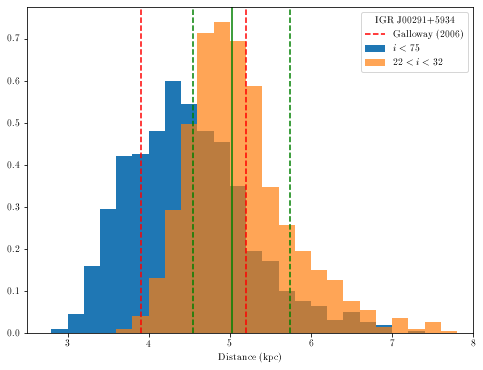

In [22]:
# Plot to compare the 2 distributions

fig1 = plt.figure()
fig1.set_size_inches(8,6)
with quantity_support():
    plt.hist(dist_all['dist'].distribution,bins=np.arange(40)/5.,density=True, 
         label='$i<{:.0f}$'.format(cd.IMAX_NDIP))

    plt.hist(dist['dist'].distribution,bins=np.arange(40)/5.,alpha=0.7,density=True,
        label='${:.0f}<i<{:.0f}$'.format(22,32))
plt.xlim(2.5,8)
plt.xlabel('Distance (kpc)')
# plt.text(7.7, .67, src, horizontalalignment='right')

plt.axvline(dper[0],color='g')
plt.axvline(dper[1],color='g',ls='--')
plt.axvline(dper[2],color='g',ls='--')

plt.axvline(gal06b[0],color='r',ls='--',label='Galloway (2006)')
plt.axvline(gal06b[1],color='r',ls='--')

plt.legend(title=src)

# fig1.savefig("fig1.pdf", bbox_inches='tight')

## 1 burst

Here I follow through the analysis of the (single) burst from IGR J17591-2342, from Table 3 of Kuiper et al. 2020 (https://arxiv.org/abs/2002.12154)

In [23]:
src = 'IGR J17591-2342'
t0 = 58380.96358 # MJD
instr = 'IJ1'

F_pk, F_pk_err = 76., 14. # 1e-9 erg/cm^2/s
F_pers, F_pers_err = 1.2, 0.2 # 1e-9 erg/cm^2/s
E_b, E_b_err = 1.1, 0.1 # 1e-6 erg/cm^2

Distance limits including inclination constraint 7.71 kpc_-0.65 kpc^+0.83 kpc kpc (100000 samples);
  with burst anisotropy factor averaging xi_b = 0.70


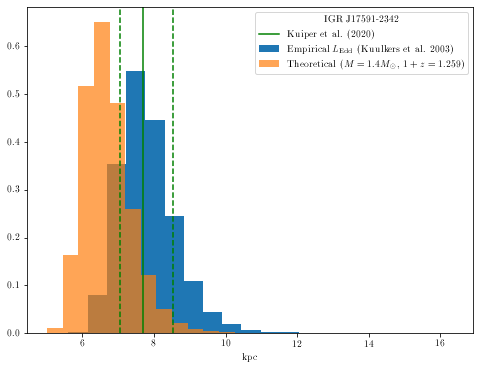

In [24]:
# There is a rough limit of 28-30 degrees for the inclination
# We can use that to constrain the various system parameters we've derived
# Use 100000 samples to make the figure for publication, with slightly smoother
# distributions
# Below we also illustrate two different ways to provide the units on the flux

dist_theo = cd.dist((F_pk, F_pk_err)*flux_unit*1e-9, empirical=False, fulldist=True, 
                    imin=24, imax=30, nsamp=100000)

dist2 = cd.dist((F_pk, F_pk_err), empirical=True, fulldist=True, 
                imin=24, imax=30, nsamp=100000)

fig2 = plt.figure()
fig2.set_size_inches(8,6)

with quantity_support():
    plt.hist(dist2['dist'].distribution,density=True,bins=20,label="Empirical $L_\mathrm{Edd}$ (Kuulkers et al. 2003)")

    plt.hist(dist_theo['dist'].distribution,density=True,bins=20,alpha=0.7,
            label='Theoretical ($M=1.4 M_\odot$, $1+z=1.259$)')
    
dper = np.percentile(dist2['dist'].distribution,(50,16,84))
plt.axvline(dper[0],color='g', label='Kuiper et al. (2020)')
plt.axvline(dper[1],color='g',ls='--')
plt.axvline(dper[2],color='g',ls='--')
# xiper = np.percentile(dist2['xi_b'][g],(50,16,84))

# These values for the paper

print ('''Distance limits including inclination constraint {:.2f}_{:.2f}^{:+.2f} kpc ({} samples);
  with burst anisotropy factor averaging xi_b = {:.2f}'''.format(
    dper[0], dper[1]-dper[0], dper[2]-dper[0], len(dist2['dist'].distribution),
    np.mean(dist2['xi_b'].distribution)))

plt.legend(title=src)

# fig2.savefig("fig2.pdf", bbox_inches='tight')

In [25]:
# Estimate the accretion rate

print (F_pers)
m2 = cd.mdot((F_pers,F_pers_err),dist2['dist'],inclination=dist2['i'],fulldist=True)#,nsamp=2000)

mdot = np.percentile(m2['mdot'].distribution,(50,16,84))
print ('''
Accretion rate implied from persistent flux, with xi_p = {:.2f} (average) is {:.0f}_{:.0f}^{:+.0f} 
  or {:.3f}_{:.3f}^{:+.3f} in units of the Eddington accretion rate'''.format(
    np.mean(m2['xi_p'].distribution),
    mdot[0].value,(mdot[1]-mdot[0]).value,mdot[2]-mdot[0], #m2['mdot'].unit,
    (mdot[0]/mdot_Edd).value,((mdot[1]-mdot[0])/mdot_Edd).value,(mdot[2]-mdot[0])/mdot_Edd))

# len(m2['mdot'].distribution)

1.2

Accretion rate implied from persistent flux, with xi_p = 0.47 (average) is 1932_-427^+564 g / (cm2 s) 
  or 0.022_-0.005^+0.006 in units of the Eddington accretion rate


This calculation determines the ignition column; in the absence of a value for Xbar, a random distribution of values is used. A uniform distribution of Xbar is not realistic, but it's hard to do better. Also, large values of Xbar are suppressed by the limit on X_0, down the track

In [26]:
# The size of the distribution has to be consistent with the distance array
nsamp = cd.len_dist(dist2['dist'])
# print (nsamp)

Xbar = unc.uniform(lower=0.0*u.dimensionless_unscaled, upper=0.7*u.dimensionless_unscaled,
                  n_samples=nsamp)

# Calculate the ignition column

y2 = cd.yign((E_b, E_b_err), dist2['dist'], inclination=dist2['i'], 
             Xbar=Xbar, fulldist=True)

# Now the recurrence time

dt1 = y2['yign']/m2['mdot']*cd.OPZ
# print (type(dt1))

In [27]:
# The combination of Xbar and recurrence time constrain X_0 and Z_CNO. 
# For each pair, we calculate the values here

Z_CNO = np.random.random(nsamp)*0.02

x_0 = np.zeros(nsamp)
for i in range(nsamp):
    # print (i,Xbar.distribution[i],Z_CNO[i],dt1.distribution[i].to('hr'))
    x_0[i] = cd.X_0(Xbar.distribution[i],Z_CNO[i],dt1.distribution[i].to('hr'))

# We restrict to physical values i.e. x_0 < 0.75

g = np.where(x_0 < 0.75)[0]

print ('Acceptance fraction {:.2f}% of {} samples'.format(100*len(g)/len(x_0), len(x_0)))

Acceptance fraction 61.50% of 100000 samples


Now we can display all the values of yign, and dt1 that meet the criterion on x_0 imposed above

In [28]:
# display results for the realistic subset of the distributions

yign = np.percentile(y2['yign'].distribution[g]/1e8,(50,16,84))
print('''
Ignition column is {:.2f}_{:.2f}^{:+.2f} e8 {}'''.format(
    yign[0].value,(yign[1]-yign[0]).value,(yign[2]-yign[0]).value,y2['yign'].unit))

dtc = np.percentile(dt1.distribution[g].to('d').value, (50,16,84))
print('''
Inferred recurrence time is {:.2f}_{:.2f}^{:+.2f} d'''.format(
    dtc[0], dtc[1]-dtc[0], dtc[2]-dtc[0]))


Ignition column is 1.66_-0.63^+1.04 e8 g / cm2

Inferred recurrence time is 1.21_-0.45^+0.78 d


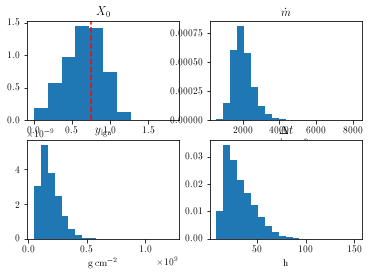

In [29]:
# Ugly but informative plot

fig3, axs3 = plt.subplots(2, 2)
with quantity_support():
    axs3[0,0].hist(x_0, density=True)
    axs3[0,0].set_title('$X_0$')
    axs3[0, 0].axvline(0.75,color='r',linestyle='--')

    axs3[0, 1].hist(m2['mdot'].distribution[g], bins=20, density=True)
    axs3[0, 1].set_title('$\dot{m}$')
    
    axs3[1, 0].hist(y2['yign'].distribution[g], bins=20, density=True)
    axs3[1, 0].set_title('$y_\mathrm{ign}$')
    
    axs3[1, 1].hist(dt1.distribution[g].to('hr'), bins=20, density=True)
    axs3[1, 1].set_title('$\Delta t$')

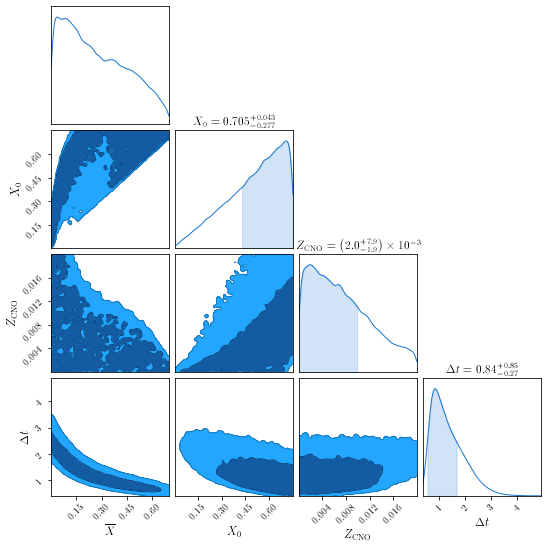

In [30]:
# using instead chainconsumer to plot; see 
# https://samreay.github.io/ChainConsumer/examples/customisations/plot_one_chain.html

data = np.vstack((Xbar.distribution[g].value, 
                  x_0[g], 
                  Z_CNO[g], 
                  dt1.distribution[g].to('d').value)).T
labels = ["$\overline{X}$", "$X_0$", "$Z_\mathrm{CNO}$", "$\Delta t$"]
# labels = ['X', '$X_0$', '$Z_\mathrm{CNO}$', '$Delta t$']

# not sure if this is necessary
matplotlib.rcParams['axes.unicode_minus'] = False

# If you pass in parameter labels and only one chain, you can also get parameter bounds
fig = ChainConsumer().add_chain(data, 
                                parameters=labels).plotter.plot(figsize=(8,8)
# uncomment the following line to save the plot
                                # ,filename='igrJ17591-2342.pdf'
                                )

In [40]:
import pickle

with open("analysis.p","wb") as f:
    pickle.dump(((src, t0, instr), (F_pk, F_pk_err), (F_pers, F_pers_err), (E_b, E_b_err), 
        nsamp, dist2), f)
#     pickle.dump(((src, t0, instr), (F_pk, F_pk_err), (F_pers, F_pers_err), (E_b, E_b_err), 
#         nsamp, dist_theo, dist2, m2, y2, Xbar, x_0, Z_CNO, dt1, g), f)
type(dist_theo['dist'])



PicklingError: Can't pickle <class 'astropy.uncertainty.core.QuantityDistribution'>: attribute lookup QuantityDistribution on astropy.uncertainty.core failed

## 1 (or more) bursts, no recurrence times

See the example for XMMU J181227.8-181234 below. Here 6 bursts were observed over an exposure time of 0.3446 d, with many gaps in between. So we compute a distribution of mean recurrence times consistent with the measurements, and propagate this distribution through to the rest of the calculation

Assumed M_NS = 1.4 solMass, R_NS = 11.2000 km, 1+z = 1.2590, Z_CNO = 0.02
Synthetic distribution of tdel has 1.378_-0.514^0.485 h


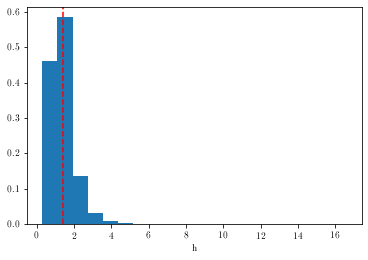

In [31]:
# Observations

exp = (0.3446*u.d).to('hr') # total exposure
nburst = 6 # total number of bursts observed (excluding SWT bursts)

fluen, fluene = 0.0241, 0.0073 # 1e-6 erg/cm^2
# fluen *= 2. # for testing
# fluene *=2.
# tdel, tdel_err = 1.38*u.hr, 0.56*u.hr
pflux, pfluxe = 1.19, 0.16 # 1e-9 erg/cm^2/s
bc = 2.522
f_unit = 1e-9*u.erg/u.cm**2

# Assumptions here

opz_def = cd.redshift(1.4*const.M_sun,11.2*u.km)

xmax = 0.77
zcno_def = 0.02
# zcno_def = 0.05 # acceptance fraction up to 13%
nbin=1000000 # for paper plots
# nbin=2000 # for testing

# some tests here

# opz_def*=1.1

z_def = opz_def-1.
print ("Assumed M_NS = {}, R_NS = {:.4f}, 1+z = {:.4f}, Z_CNO = {}".format(
#    M_NS,R_NS,1.+z_def,zcno_def))
    1.4*u.M_sun,11.2*u.km,1.+z_def,zcno_def))

# Estimate tdel and error based on Poisson stats
# could package this up into a function
    
tdel_arr = cd.tdel_dist(nburst, exp, nsamp=nbin)
tdel = exp/nburst

# lim = np.percentile(y,(16,50,84))
lim = np.percentile(tdel_arr.distribution,(16,50,84))
# print (lim[1],lim[0],lim[2])
# print ('Synthetic distribution of tdel has {:.3f}_{:.3f}^{:.3f}'.format(
#     tdel.value,(exp/lim[2]-tdel).value,exp/lim[0]-tdel))
print ('Synthetic distribution of tdel has {:.3f}_{:.3f}^{:.3f}'.format(
    tdel.value,(lim[0]-tdel).value,lim[2]-tdel))

with quantity_support():
    plt.hist(tdel_arr.distribution,bins=20,density=True)
    plt.axvline(tdel,linestyle='--',color='r')

1000000 1000000
alpha = 573.59 (68% range 351.33-1002.26)


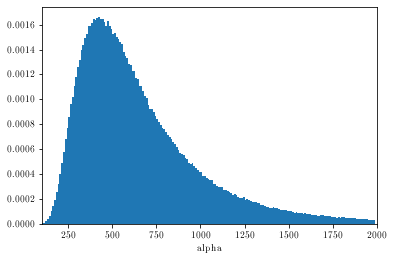

In [9]:
# Calculate alpha and plot the histogram, using the concord routine

# alpha = pflux*f_unit/u.s*bc*tdel.to('s')/(fluen*f_unit)
alpha = cd.alpha(tdel_arr,(fluen,fluene),(pflux,pfluxe),bc, fulldist=True)
alpha['alpha'].distribution

print(cd.len_dist(tdel_arr), cd.len_dist(alpha['alpha']))
with quantity_support():
    plt.hist(alpha['alpha'].distribution,bins=np.arange(0,2000,10),density=True)
plt.xlabel('alpha')
plt.xlim(100,2000)
# print (len(alpha))
# print (np.isscalar(alpha[3]))

# Also show the statistics

ap = np.percentile(alpha['alpha'].distribution,(16,50,84))
print ("alpha = {:.2f} (68% range {:.2f}-{:.2f})".format(ap[1],ap[0],ap[2]))

# print (len(alpha))

1000000 1000000
22252 1000000
Accepting 2.2252% of samples
For assumed 1+z = 1.2590, Z_CNO = 0.020, X_0 = 0.0535_0.0262^0.1037 (< 0.1572 @ 95%)
i = 51.0_28.2^67.8 deg


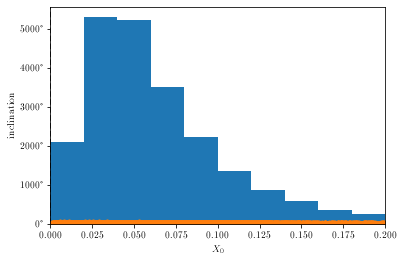

In [10]:
# Now calculate the H-fraction at ignition, and the corresponding fuel composition
# and sytem inclination. Make sure to include fulldist=True to get the distributions

Z_CNO = np.random.random(nbin)*0.02

print (cd.len_dist(tdel_arr), cd.len_dist(alpha['alpha']) )
# Initial version of this calculation just used the fixed value of Z_CNO; but here
# we follow the earlier analysis by having a randomly distributed set of values
xbar = cd.hfrac(tdel_arr,alpha['alpha'],1+z_def,
                # zcno=zcno_def,
                zcno=Z_CNO,
                isotropic=False,fulldist=True)#,debug=True)

# cd.len_dist(tdel_arr), cd.len_dist(alpha), cd.len_dist(_x_0)

plt.hist(xbar['X_0'].distribution,bins=np.arange(0.,0.3,0.02))
plt.xlim(-0.1,0.8)
# plt.ylim(0,200)
plt.xlabel('inferred X_0')
plt.axvline(x=xmax,linestyle='--',color='k')
plt.axvline(x=0,linestyle='--',color='k')

good=np.where(np.logical_and(xbar['X_0'].distribution <= xmax,xbar['X_0'].distribution > 0))[0]
print (len(good), cd.len_dist(alpha['alpha']))

# Stats on the accepted samples

print ("Accepting {}% of samples".format(
    100.*len(good)/cd.len_dist(alpha['alpha'])))

# Display results
xp = np.percentile(xbar['X_0'].distribution[good],(50,16,84,95))
print ("For assumed 1+z = {:.4f}, Z_CNO = {:.3f}, X_0 = {:.4f}_{:.4f}^{:.4f} (< {:.4f} @ 95%)".format(
    1+z_def,zcno_def,xp[0], xp[1], xp[2], xp[3]))
ip = np.percentile(xbar['i'].distribution,(50,16,84))
print ("i = {:.1f}_{:.1f}^{:.1f}".format( ip[0].value, ip[1].value, ip[2]))

with quantity_support():
    # "bad" values are returned as -1, so no need to highlight the "good"
    plt.plot(xbar['X_0'].distribution,xbar['i'].distribution,'.')
    plt.xlim(0,0.2)
    plt.xlabel('$X_0$')
    plt.ylabel('inclination')
    # plt.plot(_x_0.distribution[good],i.distribution[good],'.')

In [7]:
xbar.keys()

dict_keys(['xbar', 'X_0', 'i', 'alpha', 'fluen', 'fper', 'model'])

In [21]:
# Here we write out all the results

import pandas as pd

print (cd.len_dist(tdel_arr),cd.len_dist(alpha),
       # cd.len_dist(_x_0),cd.len_dist(i),cd.len_dist(xbar)
       cd.len_dist(xbar['X_0']), cd.len_dist(xbar['i']), cd.len_dist(xbar['xbar']))
# xi_p, xi_b = cd.diskmodel.anisotropy(i)
xi_p, xi_b = cd.diskmodel.anisotropy(xbar['i'])

# d = {'fluen': fluen, 'pflux': pflux, 'tdel': tdel_arr, 'alpha': alpha,
d = {'tdel': tdel_arr, 'alpha': alpha.distribution,
     # 'xbar': xbar, 'x_0': _x_0, 'theta': i, 
     'xbar': xbar['xbar'].distribution, 'x_0': xbar['X_0'].distribution, 'theta': xbar['i'].distribution,
     'xi_p': xi_p.distribution, 'xi_b': xi_b.distribution}

results = pd.DataFrame(data = d)
# plt.hist(results['alpha'],bins=100)
# results.to_csv('1812-182_sim_results.csv')

1000000 1000000 1000000 1000000 1000000


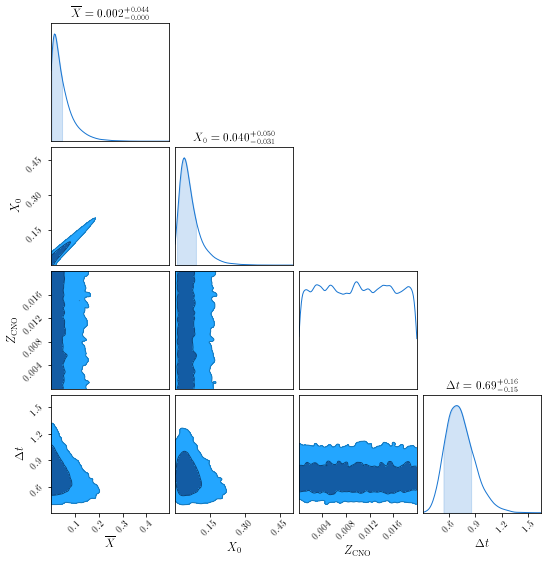

In [11]:
# and display, copying the approach from the previous source

data = np.vstack((xbar['xbar'].distribution[good], 
                  xbar['X_0'].distribution[good], 
                  Z_CNO[good], 
                  tdel_arr.distribution[good].value)).T
labels = ["$\overline{X}$", "$X_0$", "$Z_\mathrm{CNO}$", "$\Delta t$"]
# labels = ['X', '$X_0$', '$Z_\mathrm{CNO}$', '$Delta t$']

# not sure if this is necessary
matplotlib.rcParams['axes.unicode_minus'] = False

# If you pass in parameter labels and only one chain, you can also get parameter bounds
fig = ChainConsumer().add_chain(data, 
                                parameters=labels).plotter.plot(figsize=(8,8)
# uncomment the following line to save the plot
                                # ,filename='xmmuj181227.8-181234.pdf'
                                )

## Reference burst application - 4U 1820-30

For the three sources in the reference burst sample, we have moderately good constraints on the composition; so test how well the current analyses reproduce those values here

First read in the data from the reference burst sample; this is done as part of `concord`, where we define an arbitrary burst for the sake of accessing the table (this could be achieved more simply)

In [31]:
# It doesn't matter which burst you choose here, I think; this is just
# to trigger concord to read the reference burst table

obs = cd.ObservedBurst.ref('GS 1826-24', 3.5)

i = 6 # select the first epoch burst from 1820
obs.table[i]

Epoch,$N_{\rm burst}$ ($N_{\rm av}$),burst IDs$^a$,$\Delta t$ (hr),$F_{\rm per}^b$ ($10^{-9}\ \epcs$),$c_{\rm bol}$,$\dot{m}$ ($\dot{m}_{\rm Edd}$),$E_b$ ($10^{-6}\ \epc$),$F_{\rm pk}$ ($10^{-9}\ \epcs$),$\alpha$,file
str11,str5,str6,str28,str15,str16,str10,str15,str17,str13,str26
1997 May 4,3(1),1,$2.681\pm0.007$,$3.72\pm0.18$,$1.45\pm0.09$,0.144,$0.381\pm0.003$,$61\pm2$,$138.5\pm1.4$,4u1820-303_2.681h.dat


In [3]:
# This routine is redundant; see instead cd.decode_LaTeX

import re

def tex2val(tex_str):
    """
    For string LaTeX values of the form $2.681\\pm0.007$, will return the value and error
    """
    
    m = re.findall('[.\d]+', tex_str)

    if len(m) == 1:
        print ('** WARNING ** only single numeric element')
        return float(m[0])
    
    return float(m[0]), float(m[1])

In [32]:
f_unit = u.erg/u.cm**2/u.s
nsamp = 1000

# Extract the data from this row and plot the alpha values

print (obs.table[i][0], obs.table[i][3], obs.table[i][4], obs.table[i][5], obs.table[i][7])

# Convert table strings to quantities (and errors, where available)
tdel = cd.decode_LaTeX(obs.table[i][3])
fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
bc = cd.decode_LaTeX(obs.table[i][5])
# Could calculate alpha via the other parameters, should really incorporate this into hfrac
# alpha = tex2val(obs.table[i][9])
# alpha =  np.random.normal(0., 1., size=nsamp) * alpha[1] + alpha[0]

# Here's the (new) built-in calculation in concord, for comparison

# if tdel[1] is None:
#     tdel = tdel[0]
# if bc[1] is None:
#     bc = bc[0]


1997 May 4 $2.681\pm0.007$ $3.72\pm0.18$ $1.45\pm0.09$ $0.381\pm0.003$


1997 May 4 (2.681, 0.007) (0.381, 0.003) (3.72, 0.18) (1.45, 0.09)
[136.17224228  10.1158284   10.75106383]


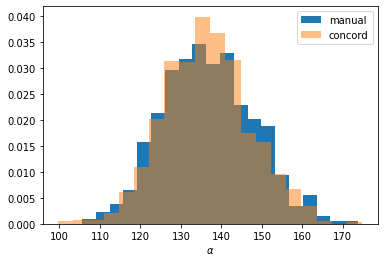

In [33]:
print (obs.table[i][0], tdel, (fluen, fluene), (fper, e_fper), bc)

alpha2 = cd.alpha(tdel*u.hr, (fluen, fluene), (fper, e_fper), bc, fulldist=True)
alpha2 = alpha2['alpha']

# Original (manual) calculation below, for comparison

_fluen = np.random.normal(loc=fluen, scale=fluene, size=nsamp)
_pflux = np.random.normal(loc=fper, scale=e_fper, size=nsamp)
if (np.shape(bc) != ()) & (bc[1] is not None):
    _bc = np.random.normal(loc=bc[0], scale=bc[1], size=nsamp)
else:
    _bc = bc
# Calculate alpha and plot the histogram

if (np.shape(tdel) != ()) & (tdel[1] is not None):
    _tdel =  (np.random.normal(0., 1., size=nsamp) * tdel[1] + tdel[0])*u.hr
else:
    _tdel *= u.hr
alpha = _pflux*f_unit/u.s*_bc*_tdel.to('s')/(_fluen*1000*f_unit)

# compare with the concord version

with quantity_support():
    plt.hist(alpha, bins=20, density=True, label='manual')
    #print (np.shape(tdel), np.shape())
    plt.hist(alpha2.distribution, bins=20, density=True, alpha=.50, label='concord')
plt.xlabel('$\\alpha$')
plt.legend()

ac = np.percentile(alpha2.distribution,[50,50-cd.CONF/2.,50+cd.CONF/2.])
print (cd.intvl_to_errors(ac))

1997 May 4 (2.681, 0.007) (0.381, 0.003) (3.72, 0.18) (1.45, 0.09)
Acceptance fraction 55.50% of 1000 samples
[51.22676417 39.8667856  60.14959365 63.59022384] deg
[0.1716554  0.09351689 0.23638727 0.27451875]
[0.1716554  0.0781385  0.06473187]


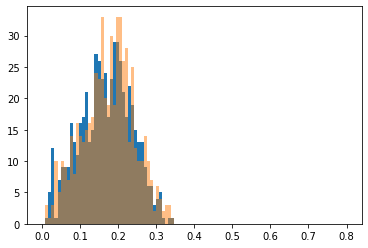

In [54]:
# Demonstrate result for one epoch

print (obs.table[i][0], tdel, (fluen, fluene), (fper, e_fper), bc)

xbar = cd.hfrac(tdel, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=bc, 
                    imin=34, imax=81, fulldist=True) # inclination limits from Hauke's paper

# can do a few different treatments for Z_CNO

Z_CNO = np.random.random(cd.NSAMP_DEF)*0.02
xbar_z = cd.hfrac(tdel, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=bc, zcno=Z_CNO,
                    imin=34, imax=81, fulldist=True) # inclination limits from Hauke's paper

xbar.keys()

pos = np.where(xbar['X_0'].distribution > 0.)[0]
pos_z = np.where(xbar_z['X_0'].distribution > 0.)[0]

print ('Acceptance fraction {:.2f}% of {} samples'.format(
    100*len(pos)/len(xbar['X_0'].distribution), len(xbar['X_0'].distribution)))

with quantity_support():
    plt.hist(xbar['X_0'].distribution[pos],bins=np.linspace(0,0.8,100))
    plt.hist(xbar_z['X_0'].distribution[pos_z],bins=np.linspace(0,0.8,100),alpha=0.5)
    # plt.hist(xbar['i'].distribution[pos],bins=np.linspace(0,90,90))
    # plt.plot(xbar['i'].distribution[pos], xbar['X_0'].distribution[pos],'.')
    # plt.axvline(34,linestyle='--',color='r')
    # plt.axvline(81,linestyle='--',color='r')
# print(np.linspace(0,0.8,100))
print (np.percentile(xbar['i'].distribution[pos],[50,50-cd.CONF/2.,50+cd.CONF/2.,95.]))
print (np.percentile(xbar['X_0'].distribution[pos],[50,50-cd.CONF/2.,50+cd.CONF/2.,95.]))
print (cd.intvl_to_errors(np.percentile(xbar['X_0'].distribution[pos],
                                       [50,50-cd.CONF/2.,50+cd.CONF/2.])))

6 $2.681\pm0.007$ $3.72\pm0.18$ $1.45\pm0.09$ $0.381\pm0.003$
(2.681, 0.007) (0.381, 0.003) (3.72, 0.18) (1.45, 0.09)
95-percent upper limit on X_0 = 0.283 (573 samples)
7 $1.892^e$ $5.70\pm0.04$ 1.4981 $0.371\pm0.010$
(1.892, None) (0.371, 0.01) (5.7, 0.04) (1.4981, None)
95-percent upper limit on X_0 = 0.185 (483 samples)


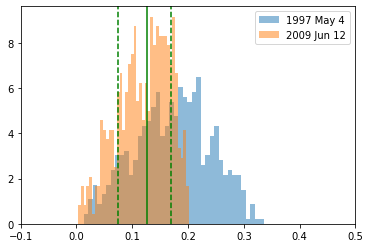

In [55]:
# First run goes through and does both 1820-30 bursts
for i in np.arange(2)+6:
    print (i,obs.table[i][3], obs.table[i][4], obs.table[i][5], obs.table[i][7])

    tdel = cd.decode_LaTeX(obs.table[i][3])
    fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
    fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
    c_bol = cd.decode_LaTeX(obs.table[i][5])
    
    print (tdel, (fluen, fluene), (fper, e_fper), c_bol)
    
    # for the second pass, use the inclination as the prior for the second data set
    
    if i>6:
        xbar_com = cd.hfrac(tdel, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=c_bol, 
                               inclination=xbar['i'], fulldist=True) # inclination prior from previous run

    xbar = cd.hfrac(tdel, fluen=(fluen, fluene), fper=(fper, e_fper), c_bol=c_bol, 
                               imin=34, imax=81, fulldist=True) # inclination limits from Hauke's paper
# determine 95% limit on X_0

    g = np.where(xbar['X_0'].distribution >= 0)[0]
    plt.hist(xbar['X_0'].distribution[g], bins=40, alpha=0.5, density=True, label=obs.table[i][0])
    
    # if i>6:
    #     plt.hist(xbar_com['X_0'].distribution[g], bins=40, alpha=0.5, density=True, label='combined')


    xlim = np.percentile(xbar['X_0'].distribution[g],(18,50,84,95))

    print ('95-percent upper limit on X_0 = {:.3f} ({} samples)'.format(xlim[3], 
          len(g)))

plt.legend()
plt.xlim(-0.1,0.5)
# plt.ylim(0,4)
# plt.axvline(0.,linestyle='--',color='r')

plt.axvline(xlim[0],linestyle='--',color='g')
plt.axvline(xlim[1],linestyle='-',color='g')
plt.axvline(xlim[2],linestyle='--',color='g')

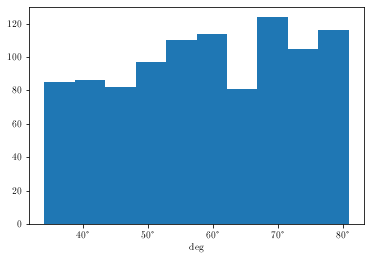

In [42]:
with quantity_support():
    plt.hist(xbar['i'].distribution)

The paper may only include the case of 4U 1820-30; also testing here with GS 1826-24

For GS 1826-24, Meisel et al. (2018) suggested an inclination of 65 or 80 deg; Johnston et al. (2020) found $i = 69^{+2}_{-3}$ degrees. Lack of dipping would suggest its $\lesssim75$

In [9]:
# Now try one of the epochs for 1826-24

i = 0 # select the first epoch burst from 1826
obs.table[i]

Epoch,$N_{\rm burst}$ ($N_{\rm av}$),burst IDs$^a$,$\Delta t$ (hr),$F_{\rm per}^b$ ($10^{-9}\ \epcs$),$c_{\rm bol}$,$\dot{m}$ ($\dot{m}_{\rm Edd}$),$E_b$ ($10^{-6}\ \epc$),$F_{\rm pk}$ ($10^{-9}\ \epcs$),$\alpha$,file
str11,str5,str6,str28,str15,str16,str10,str15,str17,str13,str26
1998 Jun,6(1),7,$5.14\pm0.07$,$1.167\pm0.006$,$1.806\pm0.009$,0.0513,$1.102\pm0.011$,$30.9\pm1.0$,$34.2\pm0.5$,gs1826-24_5.14h.dat


$5.14\pm0.07$ $1.167\pm0.006$ $1.806\pm0.009$ $1.102\pm0.011$
(5.14, 0.07) 1.102 1.167 (1.806, 0.009)
** WARNING ** this quantity is already a distribution
(4.177, 0.01) 1.126 1.593 (1.787, 0.003)
** WARNING ** this quantity is already a distribution
(3.53, 0.004) 1.18 1.87 (1.751, 0.003)
** WARNING ** this quantity is already a distribution


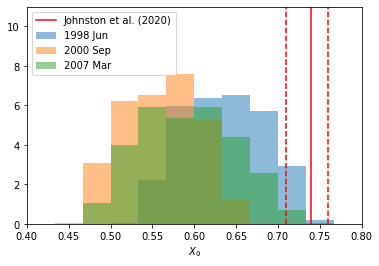

In [10]:
print (obs.table[i][3], obs.table[i][4], obs.table[i][5], obs.table[i][7])

# Loop over the three epochs and determine the X_0 distribution for each one, comparing with
# Johnston et al. 20

for i in range(3):
    tdel = cd.decode_LaTeX(obs.table[i][3])
    fper, e_fper = cd.decode_LaTeX(obs.table[i][4])
    fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
    bc, bce = cd.decode_LaTeX(obs.table[i][5])
# Could calculate alpha via the other parameters, should really incorporate this into hfrac
# alpha = tex2val(obs.table[i][9])
# alpha =  np.random.normal(0., 1., size=nsamp) * alpha[1] + alpha[0]

# Here's the (new) built-in calculation in concord, for comparison

    print (tdel, fluen, fper, (bc, bce))

    alpha = cd.alpha(tdel, (fluen, fluene), (fper, e_fper), (bc, bce))
    # plt.hist(alpha.distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(30)/2.+30.)
    xbar, X_0, incl = cd.hfrac(tdel, alpha, imin=66, imax=71)#, imin=65, imax=80)
    plt.hist(X_0.distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(30)/30.,density=True)

plt.xlabel('$X_0$')
plt.axvline(0.74,color='r',label='Johnston et al. (2020)') # central value from johnston20
plt.axvline(0.74-0.03,color='r',linestyle='--')
plt.axvline(0.74+0.02,color='r',linestyle='--')
plt.xlim(0.4,0.8)
plt.ylim(0,11)
plt.legend()

** WARNING ** this quantity is already a distribution


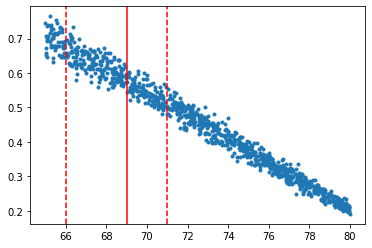

In [11]:
# This plot shows the dependence of the inferred composition on the inclination, for one
# epoch

xbar, X_0, incl = cd.hfrac(tdel, alpha, imin=65, imax=80)#, debug=True)
plt.plot(incl.distribution,X_0.distribution,'.')
plt.axvline(69,color='r')
plt.axvline(69-3,color='r',linestyle='--')
plt.axvline(69+2,color='r',linestyle='--')

In [12]:
# Now try the 3 epochs for 1808-369

i = 3 # select the first epoch burst from 1826
obs.table[i]

# fper, e_fper = tex2val(obs.table[i][4])
# print (fper, e_fper)

Epoch,$N_{\rm burst}$ ($N_{\rm av}$),burst IDs$^a$,$\Delta t$ (hr),$F_{\rm per}^b$ ($10^{-9}\ \epcs$),$c_{\rm bol}$,$\dot{m}$ ($\dot{m}_{\rm Edd}$),$E_b$ ($10^{-6}\ \epc$),$F_{\rm pk}$ ($10^{-9}\ \epcs$),$\alpha$,file
str11,str5,str6,str28,str15,str16,str10,str15,str17,str13,str26
2002 Oct,1(1),2,$16.55\pm0.06^c$,2.541--2.298,$2.085\pm 0.019$,0.0472$^d$,$2.649\pm0.018$,$229\pm4$,$114.4\pm1.9$,saxj1808.4-3658_16.55h.dat


3 2.541 2.298
(16.55, 0.06) 2.649 2.4195 (2.085, 0.019)
** WARNING ** this quantity is already a distribution
4 2.298 1.946
(21.1, None) 2.99 2.122 (2.13, 0.04)
** WARNING ** this quantity is already a distribution
5 1.946 1.826
(29.82, None) 3.46 1.8860000000000001 (2.157, 0.002)
** WARNING ** this quantity is already a distribution


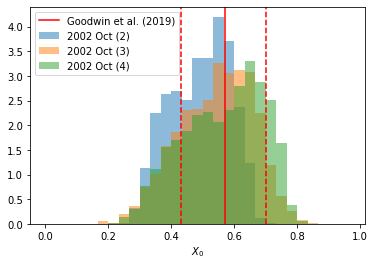

In [13]:
# Loop over the three epochs and determine the X_0 distribution for each one, comparing with
# Goodwin et al. 2019
# Wang et al. (2013) had i=50^{+6}_{-5}, Cackett et al. (2009) had 55^{+8}_{-4}
# Select a conservative range of inclinations covering both ranges

for i in np.arange(3)+3:
    tdel = cd.decode_LaTeX(obs.table[i][3])
    # persistent flux is given as a range not value with error
    # fper, e_fper = tex2val(obs.table[i][4])
    fmin, fmax = cd.decode_LaTeX(obs.table[i][4])
    # print (i, fmin, fmax)
    fper, e_fper = 0.5*(fmin+fmax), 0.5*(fmax-fmin)
    fluen, fluene  = cd.decode_LaTeX(obs.table[i][7])
    bc, bce = cd.decode_LaTeX(obs.table[i][5])
# Could calculate alpha via the other parameters, should really incorporate this into hfrac
# alpha = tex2val(obs.table[i][9])
# alpha =  np.random.normal(0., 1., size=nsamp) * alpha[1] + alpha[0]

# Here's the (new) built-in calculation in concord, for comparison

    print (tdel, fluen, fper, (bc, bce))

    alpha = cd.alpha(tdel, (fluen, fluene), (fper, e_fper), (bc, bce))
    # plt.hist(alpha.distribution,alpha=0.5,label=obs.table[i][0],bins=np.arange(30)/2.+30.)
    xbar, X_0, incl = cd.hfrac(tdel, alpha, imin=45, imax=63)#, debug=True)
    plt.hist(X_0.distribution,alpha=0.5,label=obs.table[3][0]+' ('+str(i-1)+')',bins=np.arange(30)/30.,density=True)

plt.xlabel('$X_0$')
plt.axvline(0.57,color='r',label='Goodwin et al. (2019)') # central value from johnston20
plt.axvline(0.57-0.14,color='r',linestyle='--')
plt.axvline(0.57+0.13,color='r',linestyle='--')
# plt.xlim(0.4,0.8)
# plt.ylim(0,11)
plt.legend()

## Observation-model comparisons

Here we provide examples as used in section 3.5 of the paper, which concerns model-observation comparisons

The simplest case is where we use a code like `settle` which predicts burst recurrence time and fluence, for a given accretion rate. We describe below how to do the comparison _to be written_

In [2]:
# for the 1820-30 observations on 1997 May 27

d = 7.6*u.kpc
i = 50*u.deg
X_0 = 0.17
Z_CNO = 0.02

mdot = 0.144 # in units of mdot_Edd
# this is how we would convert to mdot in g/s/cm^2 as used internally in settle
# mdot *= 1.75*(1.7/(1+X_0))*(1e-8)*(5.01837638e24*u.g/u.s)/(11.2*u.km)**2
# but gal17a throughout uses a fixed value of 8.8×10^4 g cm−2 s−1
mdot *= 8.8e4*u.g/u.cm**2/u.s * 4.*np.pi*(11.2*u.km)**2

# Settle model predictions give the following
# >>> settle(0.15,0.02,0.17,0.144,1,1.4,11.2)
# rec.array([(2.24151435, 3.13472479, 161.05916546)],
#           dtype=[(‘tdel’, ‘<f8’), (‘E_b’, ‘<f8’), (‘alpha’, ‘<f8’)])

mdot.to('g s-1')# cm-2')

<Quantity 1.99751971e+17 g / s>

In [4]:
# Initially I wanted to set z=0 because the settle results might already be redshifted
# but this will result in Q_grav = 0.0
# cd.fper(mdot, (d, i, 1.0, 0.0))

cd.fper(mdot, (d, i, cd.OPZ, 0.0))#, c_bol=1.45)

<Quantity 4.72479546e-09 erg / (cm2 s)>

Could then use a "flux" method, which would apply the distance and anisotropy factors, to calculate the fluence. Then can compare the (redshifted?) recurrence time and other params with the observations

The full comparison is where we also incorporate the comparison of the lightcurve. That's described here

In [2]:
# First read in some test data and generate an ObservedBurst object

obs = cd.ObservedBurst.ref('GS 1826-24', 3.5)


ObservedBurst parameters:
  tdel = 3.5300 h
  Fluence = 1.237e-06 +/- 9.400e-09 erg / cm2
  F_per = 1.8700e-09 erg / (cm2 s) +/- 2.0000e-11 erg / (cm2 s)
  Bolometric correction = 1.751
Lightcurve properties
  filename = gs1826-24_3.530h.dat
  time range = (-2.250 s,211.433 s)
  flux range = (2.300e-10 erg / (cm2 s),2.757e-08 erg / (cm2 s))


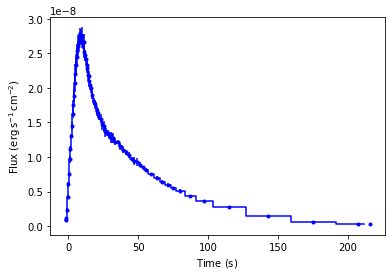

In [3]:
obs.plot()

obs.info()

In [9]:
# Now choose some random model for comparison; from Zach, 27/4/17
# after a few more bursts each:
#
# gs1   4.06 +/- 0.17
# gs2   5.30 +/- 0.17
# gs3   3.32 +/- 0.07
#
# and I've attached the newer mean lightcurves in case you also want them.
#
# Redshift is still 1.259
# 
# Mass and radius used in Kepler is 1.4 Msun and 10km, which corresponds to 11.2km radius in GR (with same mass). 
# Gravity is 1.858e+14 (cgs)
# 
# > On 27 Apr 2017, at 3:53 PM, Zac Johnston Johnston <zac.johnston@monash.edu> wrote:
# >
# > The follow ups are still running but they've got ~10 bursts each now so probably enough to have a look.
# >
# > #mod     acc rate        Z             H             Lacc/Ledd  ||  recurrence time (hr)
# > gs1   2.037000e-09    0.0050    0.7000    0.1164        ||  4.1 +/- 0.1
# > gs2   1.654625e-09    0.0050    0.7000    0.0945        ||  5.4 +/- 0.2
# > gs3   2.409750e-09    0.0050    0.7000    0.1377        ||  3.3 +/- 0.1

M_NS, R_NS = 1.4*const.M_sun, 11.2*u.km

opz = cd.redshift(M_NS, R_NS)


c_loZ = cd.KeplerBurst(filename='mean3.data',path='concord/data',
                  lAcc=0.1164,Z=0.005,H=0.7,
                  tdel=3.32/opz,tdel_err=0.07/opz,
                  g = 1.858e+14*u.cm/u.s**2, R_NS=11.2*u.km) # R_Newt=10*u.km) # would be more precise

<class 'concord.burstclass.KeplerBurst'> 4.0503909066119305e+21 kg / yr

KeplerBurst parameters:
  tdel = 2.637 h
  g = 1.8580e+14 cm / s2
  R_Newt = 9.986 km
  R_NS = 11.200 km
  1+z = 1.258
Lightcurve properties
  filename = mean3.data
  time range = (-20.222 s,160.009 s)
  luminosity range = (3.689e+35 erg / s,1.969e+38 erg / s)


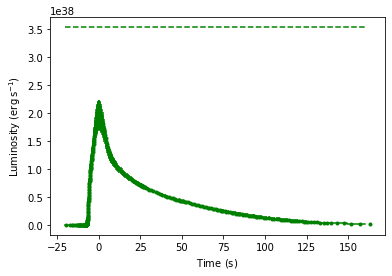

In [32]:
print (type(c_loZ), c_loZ.mdot)

c_loZ.plot()

c_loZ.info()

In [33]:
cd.mdot_Edd()

AttributeError: module 'concord' has no attribute 'mdot_Edd'

7142.675956470839

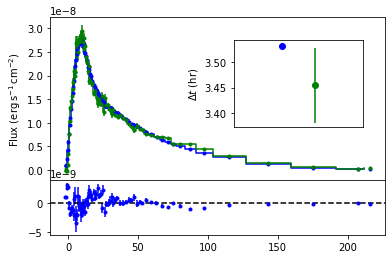

In [27]:
obs.compare(c_loZ,param = [7.5*u.kpc,60.*u.degree,1.31,-6.5*u.s], plot=True)

## Older analysis below

done up to this point following along with the paper, 2020 May; these sections not yet incorporated into the paper

Paper distance estimate for empirical Eddington flux, pure He;
  6.5 \pm 0.3 kpc, compared to my calculation 6.46 \pm 0.61 kpc
  (not sure why error seems to be a factor of 2 too small)
1.0 0.25881904510252074
Taking into account anisotropy (for all possible inclinations), 6.80_1.00^1.10 kpc
1.0 0.25881904510252074


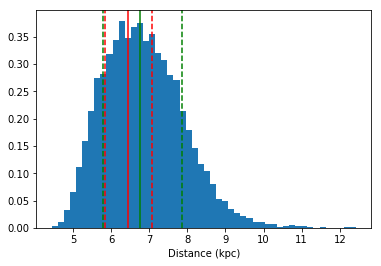

In [5]:
# This is the older analysis which replicate's Maurizio's original analysis

# Determine the distance; Maurizio gets 6.5 \pm 0.3 kpc (pure He)
# Compare what's in the curent paper draft

dhe0, dhe0_err = cd.dist(F_pk, F_pk_err, empirical=True, isotropic=True)
print ('''Paper distance estimate for empirical Eddington flux, pure He;
  6.5 \pm 0.3 kpc, compared to my calculation {:.2f} \pm {:.2f}
  (not sure why error seems to be a factor of 2 too small)'''.format( dhe0.value, dhe0_err ))

# A "better" estimate is as follows

dhe, dhe_err = cd.dist(F_pk, F_pk_err, empirical=True)
print ('Taking into account anisotropy (for all possible inclinations), {:.2f}_{:.2f}^{:.2f}'.format(
    dhe.value, -dhe_err[0].value, dhe_err[1]))

# And we now have a constraint on the inclination, 28-30 degrees, from Sanna et al;
# see the block below for those calculations

# ... and can get the full distribution like so

dist2 = cd.dist(F_pk, F_pk_err, empirical=True, fulldist=True, plot=True)
#print (len(dist2['dist']))
plt.axvline(dhe0.value,color='r')
plt.axvline((dhe0-dhe0_err).value,color='r',ls='--')
plt.axvline((dhe0+dhe0_err).value,color='r',ls='--')

# dist2['dist']

# Check the prefactor in the paper

# dist(3e-8*u.erg/u.cm**2/u.s, 0.0)

1.0 0.25881904510252074


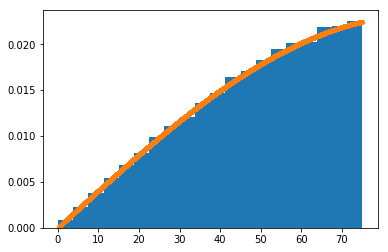

In [2]:
# Testing the idist function here

x = cd.iso_dist(nsamp=100000)
x.unit
plt.hist(x.value,bins=20,density=True)
plt.plot(x.value,np.sin(x.value/180.*np.pi)/43,'.')

0.17364817766693041 6.123233995736766e-17
Trying to replicate Hauke's latest analysis for the Eddington luminosity for 4U 0513-40
  Isotropic L_Edd = (2.82 \pm 0.32)e38 erg/s
  Including inclination constraints L_Edd = (4.96_-0.64^0.69)e38 erg/s


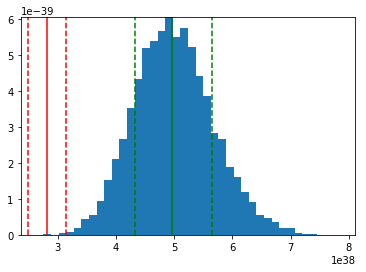

In [3]:
# Testing the L_Edd function with inclination limits

src ='4U 0513-40'
flux_unit = 1e-9*u.erg/u.cm**2/u.s
L_Edd1, L_Edd1_err = cd.L_Edd(22.2*flux_unit, 2.4*flux_unit, 10.3*u.kpc, 0.2*u.kpc, isotropic=True)
L_Edd2 = cd.L_Edd(22.2*flux_unit, 2.4*flux_unit, 10.3*u.kpc, 0.2*u.kpc, imin=80, imax=90, fulldist=True)

res = np.percentile(L_Edd2['L_Edd'],(50,16,84))/1e38
ledd_plot = plt.hist(L_Edd2['L_Edd'].value,bins=40,density=True)
plt.axvline(res[0]*1e38,color='g')
plt.axvline(res[1]*1e38,color='g',ls='--')
plt.axvline(res[2]*1e38,color='g',ls='--')
plt.axvline(L_Edd1.value,color='r')
plt.axvline((L_Edd1+L_Edd1_err).value,color='r',ls='--')
plt.axvline((L_Edd1-L_Edd1_err).value,color='r',ls='--')

print('''Trying to replicate Hauke's latest analysis for the Eddington luminosity for {}
  Isotropic L_Edd = ({:.2f} \pm {:.2f})e38 erg/s
  Including inclination constraints L_Edd = ({:.2f}_{:.2f}^{:.2f})e38 erg/s'''.format(src, 
                                            L_Edd1.value/1e38, L_Edd1_err.value/1e38,
                                            res[0],(res[1]-res[0]),res[2]-res[0]))

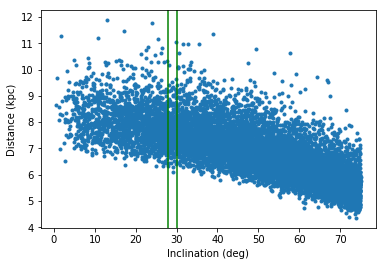

In [16]:
# Show here the relation between the inclination angle and the distance

plt.plot(dist2['i'],dist2['dist'],'.')
plt.xlabel('Inclination (deg)')
plt.ylabel('Distance (kpc)')
plt.axvline(28,color='g')
plt.axvline(30,color='g')

Paper ignition column estimate for d=6.5 kpc, He burning (Q_nuc = 1.60 MeV/nucleon):
  3.7E8 g/cm^2, compared to my (isotropic) calculation 3.70e+08 \pm 3.36e+07 g / cm2;
  or for H-burning, with Xbar set so that Q_nuc = 4.40 MeV/nucleon; 
  0.5E8 g/cm^2, compared to 1.34e+08 \pm 1.22e+07 g / cm2


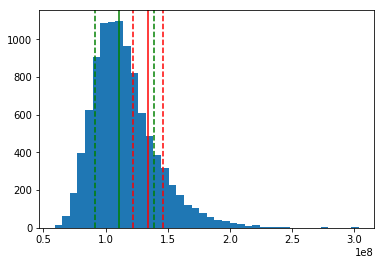

In [18]:
# Ignition column
# to get the same calculation as in the paper, we need to fudge the Xbar value to get
# Q_nuc = 4.4

Xbar = 0.5191
# print ("{} =? 4.4".format(1.31+6.95*Xbar-1.92*Xbar**2))
Xbar2 = 0.04222
# print ("{} =? 1.6".format(1.31+6.95*Xbar2-1.92*Xbar2**2))
       
yhe, yhe_err = cd.yign(E_b, E_b_err, 6.5*u.kpc, Xbar=Xbar2, isotropic=True)
yh, yh_err = cd.yign(E_b, E_b_err, 6.5*u.kpc, Xbar=Xbar, isotropic=True)
print ('''Paper ignition column estimate for d={} kpc, He burning (Q_nuc = {:.2f} MeV/nucleon):
  3.7E8 g/cm^2, compared to my (isotropic) calculation {:.2e} \pm {:.2e};
  or for H-burning, with Xbar set so that Q_nuc = {:.2f} MeV/nucleon; 
  0.5E8 g/cm^2, compared to {:.2e} \pm {:.2e}'''.format( 
    6.5, 1.31+6.95*Xbar2-1.92*Xbar2**2, yhe.value, yhe_err, 1.31+6.95*Xbar-1.92*Xbar**2, yh.value, yh_err ))

# For comparison, we here determine an updated version

y2 = cd.yign(E_b, E_b_err, dist2['dist'], inclination=dist2['i'], fulldist=True)
# print ("{:.3e}".format(y1))

y2_plot = plt.hist(y2['yign'].value,bins=40)
plt.axvline(np.percentile(y2['yign'],50),color='g')
plt.axvline(np.percentile(y2['yign'],16),color='g',ls='--')
plt.axvline(np.percentile(y2['yign'],84),color='g',ls='--')

plt.axvline(yh.value,color='r')
plt.axvline((yh-yh_err).value,color='r',ls='--')
plt.axvline((yh+yh_err).value,color='r',ls='--')

Recurrence times are 1.92 d and 0.70 d, respectively


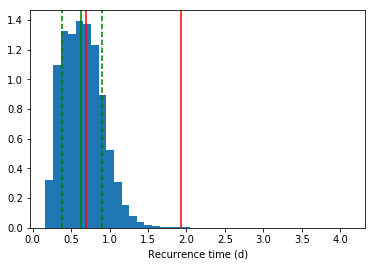

In [19]:
# Then can estimate recurrence time; first option follows the "naive" calculation

dt0_hi, dt0_lo = (yhe/m1*1.31).to('d'), (yh/m1*1.31).to('d')
print ("Recurrence times are {:.2f} and {:.2f}, respectively".format(
    dt0_hi, dt0_lo ))

# Now do a more robust one

dt1 = y2['yign']/m2['mdot']*1.31

plt.hist(dt1.to('d').value,bins=40,density=True)
plt.xlabel('Recurrence time (d)')
plt.axvline(np.percentile(dt1.to('d'),50),color='g')
plt.axvline(np.percentile(dt1.to('d'),16),color='g',ls='--')
plt.axvline(np.percentile(dt1.to('d'),84),color='g',ls='--')

plt.axvline(dt0_hi.value,color='r')#,ls='--')
plt.axvline(dt0_lo.value,color='r')#,ls='--')



[0.16500086 0.73060055]
[0.00049733 0.01677256]


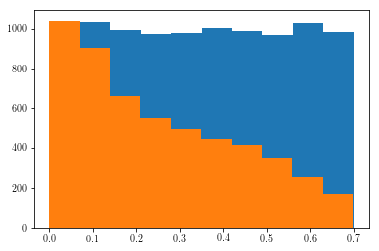

In [92]:
# plt.plot(x_0,Xbar,'.')
plt.hist(Xbar)
plt.hist(Xbar[g])

x95 = np.percentile(x_0[g],[5,95])
print (x95)
z95 = np.percentile(Z_CNO[g],[5,95])
print (z95)

## 2 or more bursts, individual measurements

Here's another example to get the column for bursts from XTE J1814-338. In this case we have multiple measurements of the recurrence time, alpha, and fluence, from MINBAR

Distance is unknown but the most energetic burst seen by _RXTE_ has spectral variations suggesting radius expansion; stroh03a used this to estimate the distance.

wang17a constrained the inclination to between 35-78 degrees

In [78]:
src = 'XTE J1814-338'

# MINBAR data:
# 3092 & 3099 are candidate short-recurrence time bursts, substantially weaker than the others
# so omit these from the analysis for now
data = np.array([# [3092, 2.325, 2.326,56.732, 1.541, 0.129, 0.002], 
                 [3095, 6.728, 6.728,89.274, 2.088, 0.248, 0.003],
                 # [3099, 1.692, 1.692,78.620, 7.198, 0.072, 0.006],
                 [3103, 6.878, 6.879,81.148, 3.884, 0.276, 0.006],
                 [3107, 6.961,13.921,90.715, 5.015, 0.252, 0.004],
                 [3109, 4.553, 4.554,52.849, 1.454, 0.270, 0.005]])

minbar = pd.DataFrame(data[0:,1:], index=data[0:,0], 
                      columns=['trec','tdel','alpha','alpha_err','bfluen','bfluene'])
minbar


,trec,tdel,alpha,alpha_err,bfluen,bfluene
3095.0,6.728,6.728,89.274,2.088,0.248,0.003
3103.0,6.878,6.879,81.148,3.884,0.276,0.006
3107.0,6.961,13.921,90.715,5.015,0.252,0.004
3109.0,4.553,4.554,52.849,1.454,0.270,0.005


In [79]:
fluen, fluene = np.mean(minbar['bfluen']), np.std(minbar['bfluen']) # 1e-6 erg/cm^2
pflux_pre, pflux_pre_e = 23.09, 1.38 # 1e-9 erg/cm^2/s
f_unit = 1e-9*u.erg/u.cm**2/u.s


In [80]:
xbar, _x_0, i = cd.hfrac(minbar['alpha'].values,minbar['tdel'].values*u.hr,isotropic=False)
print (xbar, _x_0, i)

# Calculate the distance; replicating stroh03a

d, d_err = cd.dist(pflux_pre*f_unit, pflux_pre_e*f_unit, empirical=False, X=0.7, isotropic=True)

# Perhaps more realistic

d = cd.dist(pflux_pre*f_unit, pflux_pre_e*f_unit, empirical=True, imin=35, imax=78, fulldist=True)
# print (d,d_err)

1.0 0.25881904510252074
[-0.01877318  0.26101496  0.43776537  0.11973681] [-1.          0.45615283  0.83266495  0.24874162] [74.434091   55.74161885 27.14538996 74.51927755] deg
0.8191520442889918 0.20791169081775945


In [81]:
yh, yh_err = cd.yign(fluen*1e-6*u.erg/u.cm**2, fluene*1e-6*u.erg/u.cm**2, 
                     d['dist'], inclination=d['i'], Xbar=0.3)
print ("{:.3f}_{:+.3f}^{:+.3f} \\times 10^7 g/cm^2".format(yh.value/1e7, yh_err[0].value/1e7, yh_err[1].value/1e7))

14.148_-0.996^+1.093 \times 10^7 g/cm^2


# Xbar runs
Zac incorporated Adelle's runs with measured Xbar into his grids (roughly), and the code below (copied from the "Burst matching" notebook) sets the paths and reads in an example file.

With these files we can create simulated bursts and then check the inferred Xbar with that measured from the Kepler results

In [3]:
from astropy.io import ascii

# Tried to import the modules, but there were too many unmet dependencies
# and other Zac-specific settings

# from pygrids.grid_analyser import grid_analyser

# Instead just read the summary and parameter files and read directly

# path='kepler_grids/sources/gs1826'
path = '/Users/Shared/data/kepler_grids/sources/adelle'
# data = ascii.read(path+'/summ_gs1826.txt')
data = ascii.read(path+'/summ/summ_adelle.txt')
# type(data)
# print (data.columns)

# Show cut through grid

# plt.plot(data['h'],data['z'],'.')

# param = ascii.read(path+'/params_gs1826.txt')
param = ascii.read(path+'/params/params_adelle.txt')
print (param.columns)
print ("Mass values: ",set(param['mass']))

# Show a different cut through the grid

plt.plot(param['mass'],param['accrate'],'.')
# Show histogram of mass values
# print ("Accretion rate values: ",set(param['accrate']*param['xi']))
print ("Q_b values: ",set(param['qb']))

# plt.hist(param['mass'],bins=[1.35,1.45,1.55,1.65,1.75,1.85,1.95,2.05])
# plt.ylim(0,10)

<TableColumns names=('batch','qb','x','accrate','mass','num','run','xbar','xbar_std','xign','y','z','tshift','xi','qb_delay','lburn','qnuc')>
Mass values:  {1.4}


NameError: name 'plt' is not defined

/Users/Shared/data/kepler_grids/sources/adelle mean_lightcurves/adelle_1/adelle_1_run5_mean.data
[4]
batch run     tDel      uTDel   lAcc  z    h 
----- --- ----------- --------- ---- ---- ---
    1   5 3500.726085 88.085026  0.3 0.02 0.6
batch run accrate   xbar   mass  z  
----- --- ------- -------- ---- ----
    1   5     0.3 0.562868  1.4 0.02
** WARNING ** insufficient parameters defined to convert to observed frame
1.305717832582133


AttributeError: 'KeplerBurst' object has no attribute 'print'

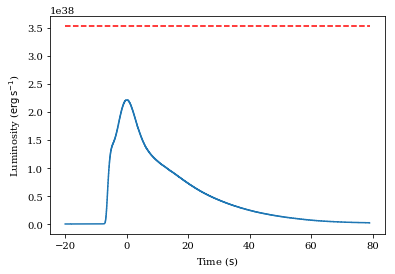

In [40]:
# Specify the model run by the batch and run number

batch=1
run=5

# slightly different filename convention here

filename='mean_lightcurves/adelle_{}/adelle_{}_run{}_mean.data'.format(
    batch,batch,run)
# filename='/mean_lightcurves/adelle_{}/'.format(batch)+filename
print (path,filename)

# lc = ascii.read(path+'/mean_lightcurves/adelle_{}/'.format(batch)+filename)
# print (lc.columns)

# Extract the corresponding model values from the table

# row=np.where(data['batch'] == 2 & data['run'] == 9)[0]
row=np.where(np.logical_and(data['batch'] == batch,data['run'] == run))[0]
prow=np.where(np.logical_and(param['batch'] == batch,param['run'] == run))[0]

# data[rows]
# print (data.columns, param.columns)
print (row)
print (data[row][['batch','run','tDel','uTDel','lAcc','z','h']])
print (param[prow][['batch','run','accrate','xbar','mass','z']])
# row=np.flatnonzero(data['batch'] == 2 & data['run'] == 9)[0]
# row
# data[row]

g = cd.g(param[prow]['mass']*const.M_sun,10*u.km)
opz = cd.opz(param[prow]['mass']*const.M_sun,10*u.km)
xbar5 = cd.KeplerBurst(filename,path=path,lAcc=data[row]['lAcc'],
                    Z=data[row]['z'],H=data[row]['h'],
                    tdel=data[row]['tDel']/opz,tdel_err=data[row]['uTDel']/opz,
                    g=g, opz=opz)
print (opz)
xbar5.plot()
xbar5.print()
# plt.plot(lc['time'],lc['luminosity'])

# Inferring Xbar
As a preliminary test, we use the set of "xbar" runs as for the paper, which have a measured Xbar (mean H-fraction at ignition).

These data can be found in the local directory concord/kepler

Lightcurve files seem to be some binary format, I don't know how to read them. Asked Adelle (8/10/18)

In [42]:
xbar_path = 'kepler/xbar-runs/'
xbar_table = ascii.read(xbar_path+'allruns_attribs.txt')

print ("Got {} runs listed in summary file".format(len(xbar_table)))

xbar_table

# Pick a random one and try to read in the file

dir='run{}'.format(floor(xbar_table['runid'][13]))
lc = xbar_path+dir+'/'+dir+'.lc'
print (lc)

Got 60 runs listed in summary file
kepler/xbar-runs/run14/run14.lc


## Simulated data
The simulated data have been created with the "Burst Matching" notebook; first we read in the tables corresponding to the observed properties, as well as the "secret" table (including the input simulation parameters)

Key columns are below:
* (tdel, tdel_err) = data['col3'], data['col4']
* (fper, fper_err) = data['col5'], data['col6']
* bc = data['col7']
* Z_CNO = data_secret['col5']
* X_0 = data_secret['col7']
* i = data_secret['col16']
* 1+z = data_secret['col17']

In [26]:
path='sim10'
data = ascii.read(path+'/sim_info.csv')
data_secret = ascii.read(path+'_secret.csv')

# data_secret
data

col1,col2,col3,col4,col5,col6,col7
int64,int64,float64,float64,float64,float64,float64
0,0,2.4473,0.0504,1.2633e-09,6e-12,1.806
0,1,2.7985,0.0591,1.0983e-09,6e-12,1.806
0,2,3.7056,0.0729,8.1417e-10,6e-12,1.806
1,0,2.7538,0.0831,3.8215e-10,6e-12,1.806
1,1,3.1466,0.0841,3.3222e-10,6e-12,1.806
1,2,4.3953,0.1557,2.4629e-10,6e-12,1.806
2,0,2.3926,0.0383,5.1541e-09,6e-12,1.806
2,1,2.7309,0.0504,4.4807e-09,6e-12,1.806
2,2,3.6777,0.0857,3.3217e-09,6e-12,1.806


Here's a test of the new routine, for one row

In [14]:
# Assumptions here

opz_def = cd.opz(1.4*const.M_sun,11.2*u.km)
z_def = opz_def-1.
zcno_def = 0.02

print ("Assumed M_NS = {}, R_NS = {:.4f}, 1+z = {:.4f}, Z_CNO = {}".format(
#    M_NS,R_NS,1.+z_def,zcno_def))
    1.4*u.M_sun,11.2*u.km,1.+z_def,zcno_def))

Assumed M_NS = 1.4 solMass, R_NS = 11.2000 km, 1+z = 1.2590, Z_CNO = 0.02


<linfit.linfit.<locals>.Bunch object at 0x11393cf28>
** WARNING ** extrapolated fluence > stat_error, replacing
Fluence: 1.302e-06 erg / cm2, tdel: 2.77750 h, alpha: 19.1646, c_bol: 1.8060
Assumed M_NS = 1.4 solMass, R_NS = 11.2000 km, 1+z = 1.2590, Z_CNO = 0.02
Inferred x_0: 1.7770, actual: 0.6800
1000
Actual M_NS = 1.4 solMass, R_NS = 25.4474 km, 1+z = 1.0927, Z_CNO = 0.0075
Check x_0: 0.5900


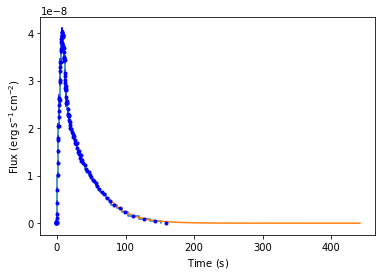

In [3]:
i=9

data['col1'][i]
b1 = ObservedBurst('sim{}_{}.csv'.format(data['col1'][i],data['col2'][i]),path=path)

# Extract all the observeables

fluen, fluene = b1.fluence(plot=True)
tdel = data['col3'][i]*u.hr
tdel_err = data['col4'][i]*u.hr
fper = data['col5'][i]*u.erg/u.cm**2/u.s
fper_err = data['col6'][i]*fper.unit
# Some question about whether the bolometric correction was correctly applied for the 
# persistent flux below
# Now resolved
c_bol = data['col7'][i]
# c_bol = 1.0
# Calculate derived quantities

alpha = tdel.to('s')*fper*c_bol/fluen
alpha_err = alpha*sqrt((tdel_err/tdel)**2+(fper_err/fper)**2
                       +(fluene/fluen)**2)

print ("Fluence: {:.4g}, tdel: {:.5f}, alpha: {:.4f}, c_bol: {:.4f}".format(
    fluen,tdel,alpha,c_bol))

# Need to calculate actual NS parameters from redshift (col17), mass
# (col13) and inclination (col16)

M_NS = data_secret['col13'][i]*u.M_sun
z_actual = data_secret['col17'][i]-1.
R_NS = (2*const.G*M_NS/const.c**2/(1.-1/(1.+z_actual)**2)).to('km')
# print (1.+z_actual," =? ",opz(M_NS,R_NS))
zcno_actual = data_secret['col5'][i]
inclination_actual = data_secret['col16'][i]*u.deg
# print (xi_b,xi_p,inclination_actual)

# Calculate the inferred value given the assumed redshift, and neglecting 
# anisotropy

xbar, x_0, i_True = hfrac(alpha,tdel,1+z_def,isotropic=True)

print ("Inferred x_0: {:.4f}, actual: {:.4f}".format(x_0,data_secret['col7'][i]))

# Try the statistical version

xbar, x_0, i_False = hfrac(alpha,tdel,1+z_def,isotropic=False)
print (len(xbar))
# plt.hist(x_0,bins=20)

# Calculate the actual value taking into account all the effects

print ("Actual M_NS = {}, R_NS = {:.4f}, 1+z = {:.4f}, Z_CNO = {}".format(
    M_NS,R_NS,1.+z_actual,zcno_actual))

# xbar_check = min([0.77,z_actual*alpha_0/alpha*(xi_b/xi_p)-0.96/6.6])
# print (xbar_check,xi_b,xi_p)
# x_0_check = min([0.77,xbar_check+0.35*(tdel/((1.+z_actual)*9.8*u.hr))*(zcno_actual/0.02)])
xbar_check, x_0_check, dummy = hfrac(alpha,tdel,opz=1+z_actual,zcno=zcno_actual,inclination=inclination_actual)
print ("Check x_0: {:.4f}".format(x_0_check))

Now loop over all the available simulated bursts and determine the h-fraction for each

In [4]:
xmax = 0.77

# specify how we want to treat the alpha values

alpha_dist = True
nsamp = 1000

# Set up the output lists

x_0_isotropic = []
x_0_best = []
x_0_actual = []
x_0 = []
x_0_err = []

# Now run the loop

for i in range(len(data)):

    data['col1'][i]
    b1 = ObservedBurst('sim{}_{}.csv'.format(data['col1'][i],data['col2'][i]),path=path)

# Extract all the observeables

    c_bol = data['col7'][i]
    fluen, fluene = b1.fluence()
    tdel = data['col3'][i]*u.hr
    tdel_err = data['col4'][i]*u.hr
    fper = data['col5'][i]*u.erg/u.cm**2/u.s
    fper_err = data['col6'][i]*fper.unit

# Calculate derived quantities

    if alpha_dist:
        alpha = ( np.random.normal(loc=tdel.to('s').value, scale=tdel_err.to('s').value, size=nsamp)
                  * np.random.normal(loc=fper.value, scale=fper_err.value, size=nsamp) * c_bol 
                  / np.random.normal(loc=fluen.value, scale=fluene.value, size=nsamp) )
    else:
        alpha = tdel.to('s')*fper*c_bol/fluen
        alpha_err = alpha*sqrt((tdel_err/tdel)**2+(fper_err/fper)**2
                       +(fluene/fluen)**2)

        print ("row {}: fluence: {:.4g}, tdel: {:.5f}, alpha: {:.4f}, c_bol: {:.4f}".format(
            i,fluen,tdel,alpha,c_bol))

# Generate values typical from earlier efforts to do this

    xbar, _x_0, dummy = hfrac(alpha,tdel,1+z_def,isotropic=True,old_relation=True)

    if alpha_dist:
        x_0_isotropic.append(min([xmax,np.percentile(_x_0,50)]))
    else:
        x_0_isotropic.append(min([xmax,_x_0]))
    x_0_actual.append(data_secret['col7'][i])

# Generate the best possible estimate

    xbar, _x_0, dummy = hfrac(alpha,tdel,data_secret['col17'][i],
                              zcno=data_secret['col5'][i],
                              isotropic=False,inclination=data_secret['col16'][i],
                              debug=True)
#    x_0_best.append(min([xmax,_x_0]))
    
    if alpha_dist:
        x_0_best.append(np.percentile(_x_0,50))
    else:
        x_0_best.append(_x_0)

# Generate more up-to-date (and hopefully more precise) estimates

    xbar, _x_0, dummy = hfrac(alpha,tdel,1+z_def,isotropic=False)
    good = np.where(_x_0 <= xmax)[0]
    if len(good) > 0:
        x_0.append(np.mean(_x_0[good]))
        x_0_err.append(0.5*(np.percentile(_x_0[good],84)
                            -np.percentile(_x_0[good],16)))
    else:
        x_0.append(xmax)
        x_0_err.append(0.0)

<linfit.linfit.<locals>.Bunch object at 0x11393cf98>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 samples to match size of alpha array
** WARNING ** assuming inclination in degrees
<linfit.linfit.<locals>.Bunch object at 0x113acbeb8>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 samples to match size of alpha array
** WARNING ** assuming inclination in degrees
<linfit.linfit.<locals>.Bunch object at 0x113abf3c8>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 samples to match size of alpha array
** WARNING ** assuming inclination in degrees
<linfit.linfit.<locals>.Bunch object at 0x1140509e8>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 samples to match size of alpha array
** WARNING ** assuming inclination in degrees
<linfit.linfit.<locals>.Bunch object at 0x113a14358>
** WARNING ** extrapolated fluence > stat_error, replacing
hfrac: adopting 1000 sam

What we find here typically is that the "best" value (using input 1+z, Z_CNO) overestimates the true value, while the isotropic value underestimates it.

The version incorporating a distribution of inclinations comes somewhere in the middle

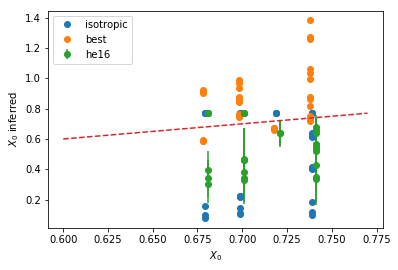

In [5]:
# poster size

# plt.figure(figsize=(10,8))

plt.plot(np.array(x_0_actual)-0.001,x_0_isotropic,"o",label='isotropic')
plt.plot(np.array(x_0_actual)-0.002,x_0_best,"o",label='best')
plt.errorbar(np.array(x_0_actual)+0.001,x_0,x_0_err,fmt="o",label='he16')

plt.plot([0.6,0.77],[0.6,0.77],'--')
plt.xlabel("$X_0$")
plt.ylabel("$X_0$ inferred")
plt.legend()

# plt.savefig('sim10_comparison.pdf')

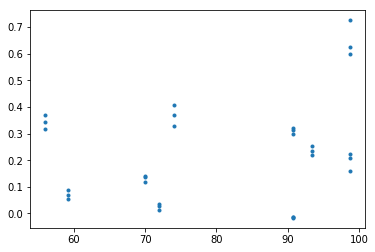

In [143]:
# Trying here to understand what gives the error we observe

# plt.hist(x_0_best-np.array(x_0_actual))
# plt.plot(data['col3']/data_secret['col17'],x_0_best-np.array(x_0_actual),'.')
plt.plot(data_secret['col7']/data_secret['col5'],x_0_best-np.array(x_0_actual),'.')

# XMMU J181227.8-181234 (= XTE J1812-182)

Here are some analysis results provided by Adelle on 14.6.18, approximate only; these were subsequently adopted in the submitted version of the paper (checked 22.2.19)

In [85]:
import astropy.stats as s

# Estimate tdel and error based on Poisson stats

exp = (0.3446*u.d).to('hr') # total exposure
nburst = 6 # total number of bursts observed (excluding SWT bursts)

# Use the function in astropy.stats

lim2 = s.poisson_conf_interval(nburst,interval='frequentist-confidence').T

print ('Best estimate of recurrence time is {:.2f}_{:.2f}^{:.2f}'.format(
    tdel.value,(exp/lim2[1]-tdel).value,exp/lim2[0]-tdel))

Best estimate of recurrence time is 1.38_-0.52^0.91 h


We run into a problem when we try to generate a synthetic distribution of recurrence times consistent with these limits, because the quoted limits given by both Gehrels et al. and the astropy.stats function poisson_conf_interval give the `n-1` value for the _lower_ limit (not sure why). I illustrate this below

0.9999998824909364


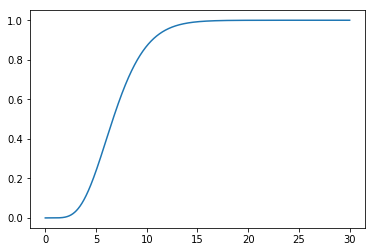

In [101]:
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.poisson.html

mean = np.arange(15000)/500. # [0-30]

# This is the cumulative PDF for the mean rate, given the detection of nburst events

c = 1-poisson.cdf(nburst,mean)

# Now plot, for illustrative purposes

plt.plot(mean,c)
print (max(c))

In [102]:
# Now finding the 1-sigma confidence levels

conf = 0.8413*2.-1. # 1-sigma = 0.6826
# "double-sided intervals... can be obtained by substituting (1+cl)/2 for cl..." (gehrels86)
conf = (1+conf)/2.
print ('Adopting 1-sided confidence value of {:.4f}'.format(conf))

iup = np.argmin(abs(c-(1-conf)))
ilo = np.argmin(abs(c-conf))

print (iup,ilo,(1-conf),conf,mean[iup],mean[ilo])
print ('Compare with range in gehrels86 of (3.620,9.584)')

Adopting 1-sided confidence value of 0.8413
2209 4792 0.15869999999999995 0.8413 4.418 9.584
Compare with range in gehrels86 of (3.620,9.584)


So the cumulative distribution limits don't match what's returned by the `poisson_conf_interval` function (nor what's in Gehrels et al. 1986). We can go ahead anyway and generate a distribution matching our function, and then propagate it through to our xbar calculation

# SAX J1810.8-2609

Here we use some analysis of three bursts observed by RXTE, and calculate the inferred X_0

For assumed 1+z = 1.2590, X_0 = 0.5527_0.3580^0.7017
i = 53.7_41.4^66.4


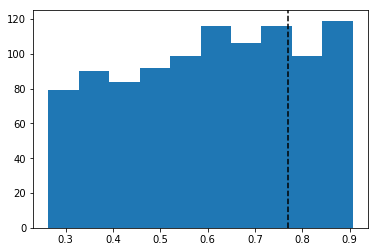

In [8]:
xbar, _x_0, i = hfrac(63.5,6.375*u.hr,1+z_def,isotropic=False)

plt.hist(_x_0)
plt.axvline(x=xmax,linestyle='--',color='k')

good=np.where(_x_0 <= xmax)[0]
print ("For assumed 1+z = {:.4f}, X_0 = {:.4f}_{:.4f}^{:.4f}".format(
    1+z_def,np.percentile(_x_0[good],50),np.percentile(_x_0[good],16),
       np.percentile(_x_0[good],84)))
print ("i = {:.1f}_{:.1f}^{:.1f}".format(
    np.percentile(i[good],50),np.percentile(i[good],16),
       np.percentile(i[good],84)))

